# Mallorquín Example

In this case we will to make a linear regression model with to try to predict the Normalized Difference Vegetation Index (NDVI) of the mangrove forest at Mallorquín Lagoon (Barranquilla, Colombia) from some hydrological variables.

## Import dependencies and hide warnings

We will use **PanDas** to load the data, **NumPy** for mathemical and vector operations, **statsmodels** to develop the linear regression model and **Matplotlib** to plot key information.

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import acf, ccf
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

plt.style.use("src/style.mplstyle")

Define the path of the data (previously prepared, see the [readme](README.md) file) and the variables to analyze

In [2]:
data_path = "data/processed/hydrological_spectral_mean_data.csv"

all_vars = ["Precipitation", "Discharge", "Temperature", "SOI", "NDVI"]
ts_vars = [all_vars[i] for i in [0, 1, 2, 4]]
in_vars = all_vars[:3]

titles = {
    "Precipitation": "Total Precipitation [mm]",
    "Discharge": "Mean River Discharge [m3 s-1]",
    "Temperature": "Mean Temperature [°C]",
    "NDVI": "Mean NDVI",
    "SOI": "Southern Oscillation Index (SOI)"
}

## Load data

Load the data and subset for the lagoon of interest (Mallorquín), also we define the Time variables as de the index. The variable of interest is the monthly mean NDVI of the mangrove forest in Mallorquín Lagoon taken from Landsat 7 and Landsat 8, to predict it we will use the monthly total precipitation at Barranquilla (in mm), the Magdalena River monthly mean discharge (in m3 s-1) taken from hydrometeorological stations, the monthly mean surface temperature (in °C) also taken from Landsat 7 and 8 and the Southern Oscillation Index from NOAA. In terms of time all variables has been mesuared from 2001 to 2021.

In [3]:
DATA = pd.read_csv(data_path, parse_dates=[1], index_col=0)
DATA = DATA[DATA.Lagoon == "mallorquin"]
DATA = DATA.set_index("Time", drop=True)

DATA.head()

,Lagoon,Precipitation,Discharge,NDVI,Temperature,PixelPercentage,SOI,ENSO
Time,,,,,,,,
2001-01-31,mallorquin,0.000000,5239.0,0.519967,28.034192,85.549645,1.6,Nina
2001-02-28,mallorquin,0.000000,2960.0,0.455979,29.304450,0.000000,2.8,Nina
2001-03-31,mallorquin,0.000000,3288.0,0.399753,30.600624,89.893617,1.5,Nina
2001-04-30,mallorquin,0.000000,3761.0,0.241325,19.575517,11.199764,0.3,Neutral
2001-05-31,mallorquin,72.704487,4556.0,0.291934,22.930609,0.000000,-0.8,Neutral


## Time Series Components

To explore data we will plot the time series components of the variables of interest (except for SOI because it would not make sense), for that we will use the previously writed function `plot_ts_components`.

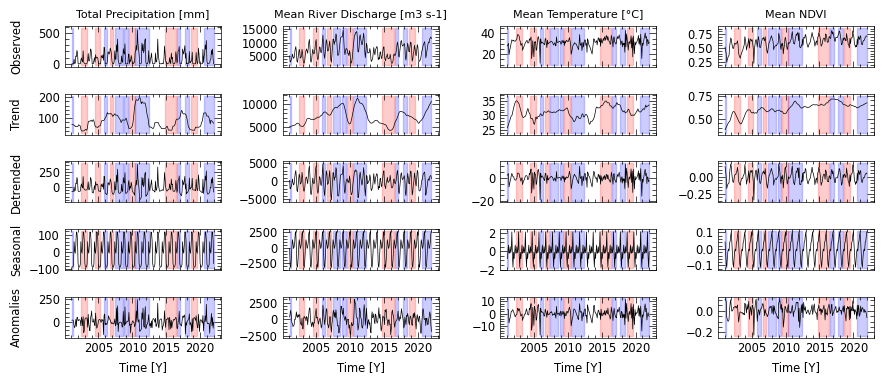

In [4]:
from src.functions.stat_utils import plot_ts_components

plot_ts_components(DATA[ts_vars], figsize=(9, 4), ENSO=DATA.ENSO, titles=titles)

plt.show()

We can see that Precipitation and Discharge have a similar behaviour, they do not shown a long term trend, but its trend is high correlated to the ENSO phases, Temperature has a similar behaviour in terms of trend but NDVI show a positive long term trend from 2001 to 2017.

To continue with the analysis we have to remove the trend, for that we will use the previously defined `detrend_variables` function.

In [5]:
from src.functions.stat_utils import detrend_variables

DATA = detrend_variables(DATA, ts_vars)

## Autocorrelation and cross-correlation

To find the maximum correlation of the variables and when its occurs we will use Autocorrelation (ACF) and Cross-correlation (CCF) plots, to calculate thwm we will use the `acf` and `ccf` functions from `statsmodels.tsa.stattools` and to plot them we will use the previously defined function `plot_acf_ccf`. We also will calculate the confidence interval.

In [6]:
from src.functions.stat_utils import plot_acf_ccf

N = DATA.shape[0]
nlags = 24
confi = 1.96/np.sqrt(N)

acf_data = {var: acf(DATA[var], nlags=nlags) for var in ts_vars}
ccf_data = {f"NDVI ~ {var}": ccf(DATA.NDVI, DATA[var])[:nlags+1] for var in in_vars}

ACF Shows that NDVI and Precipitation have a siginficant unimodal seasonal while Discharge has a significant bimodal seasonal pattern, Temperature do not show seasonal correlation

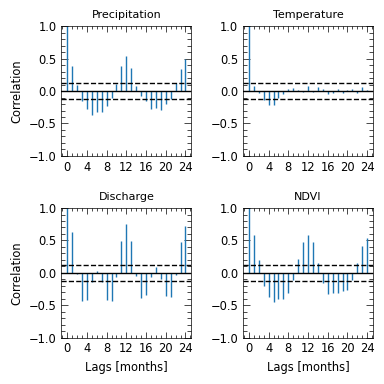

In [7]:
plot_acf_ccf(acf_data, ci=confi)

plt.show()

CCF show that the maximum correlation of NDVI with Precipitations and NDVI with Discharge are in the lags of 2 and 1 respectively, this means Precipitation affect NDVI past two months, in the case of Discharge the effect is given in the next month. Maximum correlation fo NDVI with Temperature is at lag 0, so, the effect of Temperature on NDVI is instantaneous.

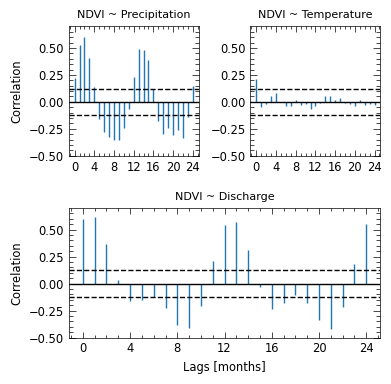

In [8]:
plot_acf_ccf(ccf_data, ci=confi, ylims=[-0.5, 0.7])

plt.show()

In [9]:
shifts = []

for key, value in ccf_data.items():
    m = np.max(np.abs(value))
    p = np.where(np.abs(value) == m)[0][0]

    shifts.append(p)
    
    print(f"{key} maximum correlation is in lag={p} ({m:0.3f})")

NDVI ~ Precipitation maximum correlation is in lag=2 (0.598)
NDVI ~ Discharge maximum correlation is in lag=1 (0.622)
NDVI ~ Temperature maximum correlation is in lag=0 (0.210)


## Linear regression model

### Prepare data

Considering the lags in correlation previously mentioned we will roll the variables, also, to reduce the noise in the SOI index, we will calulate a rolling mean of 5 months, finally we will remove the values less reliable using the image pixel percentage of 10% as the threshold.

In [10]:
for var, shift in zip(in_vars, shifts):
    DATA[var] = np.roll(DATA[var], shift)

DATA = DATA[np.max(shifts):]

DATA.SOI = DATA.SOI.rolling(window=5, min_periods=1, center=True).mean()

DATA = DATA[DATA.PixelPercentage >= 10.0]

### Correlation matrix

We will see the correlation of all variables osing `plot_corr_matrix` previously defined function.

We can see that SOI do not have correaltion with any variable, the correlation values of NDVI with the other varaibles correspond to the values of CCF and the correlation of Precipitation and Discharge is high.

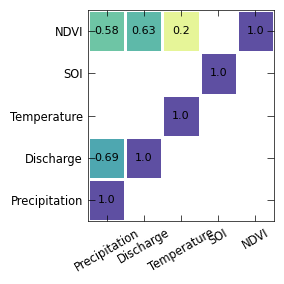

In [11]:
from src.functions.stat_utils import plot_corr_matrix

plot_corr_matrix(DATA, all_vars, True, True)

plt.show()

### Scatter plot

With a scatter plot we will se how is the behaviour of this variables, Precipitation with NDVI and Discharg with NDVI show a near-linear pattern of high positive correlation. Temperature and NDVI do not show a high correlation

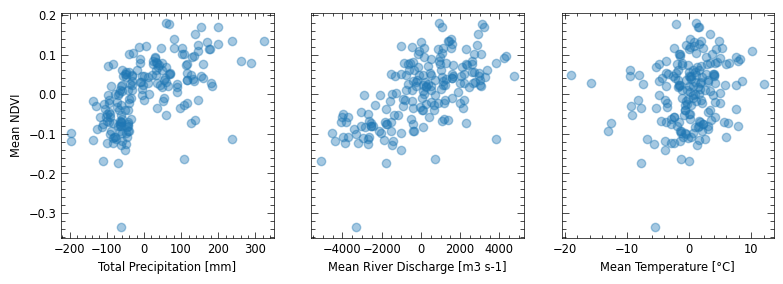

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(8, 3))

for i, (var, ax) in enumerate(zip(in_vars, axs)):
    ax.scatter(DATA[var], DATA.NDVI, alpha=0.4)
    ax.set_xlabel(titles[var])

    if i == 0:
        ax.set_ylabel(titles["NDVI"])

plt.show()

### Model

Considering the correlations, we will develop a linear regression model that account with the Precipitation, Discharge, their interaction and the Temperature to predict the NDVI. To do this we will use `statsmodels.formula`.

The high F-statistic value tell us that the model is good for explain the variability but the low R2 indicates a limited predictive power.

In [13]:
f = "NDVI ~ Precipitation*Discharge + Temperature"

m = smf.ols(f, data=DATA).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NDVI   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     48.81
Date:                Wed, 28 Dec 2022   Prob (F-statistic):           1.15e-27
Time:                        23:18:53   Log-Likelihood:                 265.36
No. Observations:                 183   AIC:                            -520.7
Df Residuals:                     178   BIC:                            -504.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0112      0.005      2.123      0.035       0.001       0.022
Precipitation               0.0003    6.6e-05      4.810      0.000       0.000       0.000
Discharge                1.524e-05   2.99e-06      5.094      0.000    9.34e-06    2.11e-05
Precipitation:Discharge -6.932e-08   2.32e-08     -2.986      0.003   -1.15e-07   -2.35e-08
Temperature                 0.0045      0.001      4.617      0.000       0.003       0.006
==============================================================================
Omnibus:                       21.074   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.686
Skew:                          -0.565   Prob(JB):                     2.41e-09
Kurtosis:                       4.982   Cond. No.                     3.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""